In [27]:
%load_ext autoreload
%autoreload 2

#standard libraries
import json
import os
import time
from collections import defaultdict
from typing import List, Dict, Tuple, Union, Callable
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from rich import print
from torch import cuda
from tqdm.notebook import tqdm
import tiktoken
from llama_index.text_splitter import SentenceSplitter
from sentence_transformers import SentenceTransformer

#external files
from preprocessing import FileIO
# from build_dataset import create_dataset, create_index
from weaviate_interface import WeaviateClient
from prompt_templates import question_answering_prompt_series, question_answering_system
from openai_interface import GPT_Turbo
from app_features import generate_prompt_series
from dotenv import load_dotenv
env = load_dotenv('../vectorsearch-applications/.env', override=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set Weaviate Client

In [4]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']

#instantiate client
client = WeaviateClient(api_key, url)

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

### Import Data

In [9]:
data_path = '../vectorsearch-applications/data/impact_theory_data.json'
data = FileIO().load_json(data_path)
print(f'Total # of episodes: {len(data)}')

Total # of episodes: 384

### Set Tokenizer and Embedding Model

In [10]:
#tokenizer
encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')
#model
model = SentenceTransformer('all-MiniLM-L6-v2')

### Chunk Data

In [4]:
corpi = []
chunk_sizes = [64, 512]
for cs in chunk_sizes:
    splitter = SentenceSplitter(chunk_overlap=0, chunk_size=cs, tokenizer=encoding.encode)
    corpus = create_dataset(data, model, splitter)
    corpi.append(corpus)

Creating dataset using chunk_size: 64

CHUNKING:   0%|          | 0/384 [00:00<?, ?it/s]

VECTORS:   0%|          | 0/384 [00:00<?, ?it/s]

2023-12-05 00:17:11.051 | INFO     | preprocessing:save_as_parquet:41 - DataFrame saved as parquet file here: ./impact-theory-minilmL6-64.parquet


Total Time to process dataset of chunk_size (64): 1.38 minutes

Creating dataset using chunk_size: 512

CHUNKING:   0%|          | 0/384 [00:00<?, ?it/s]

VECTORS:   0%|          | 0/384 [00:00<?, ?it/s]

2023-12-05 00:17:57.530 | INFO     | preprocessing:save_as_parquet:41 - DataFrame saved as parquet file here: ./impact-theory-minilmL6-512.parquet


Total Time to process dataset of chunk_size (512): 0.77 minutes

# ---------------------  BREAK -------------------------

### Load Data from disk

In [12]:
data64 = FileIO().load_parquet('path to dataset 64')
data256 = FileIO().load_parquet('path to dataset 256')
data512 = FileIO().load_parquet('path to dataset 512')

Shape of data: (119225, 12)
Memory Usage: 10.92+ MB
Shape of data: (26448, 12)
Memory Usage: 2.42+ MB
Shape of data: (12909, 12)
Memory Usage: 1.18+ MB


### Data Bundle Example

In [91]:
data256[0]

In [13]:
chunk_sizes = [64, 256, 512]
data_list = [data64, data256, data512]

### Show Chunk Size Examples

In [14]:
for size, d in zip(chunk_sizes, data_list):
    print(f'Chunk Size: {size}')
    print(f'Total # Chunks: {len(d)}')
    print(f'Sample Content: \n{d[0]["content"]}\n')
    print('-'*100)

Chunk Size: 64

Total # Chunks: 119225

Sample Content: 
You said these are dangerous times. The world order is shifting before our eyes. We also both know that with hyper 
disruptive technologies like AI on the horizon, a good outcome is not guaranteed.

----------------------------------------------------------------------------------------------------

Chunk Size: 256

Total # Chunks: 26448

Sample Content: 
You said these are dangerous times. The world order is shifting before our eyes. We also both know that with hyper 
disruptive technologies like AI on the horizon, a good outcome is not guaranteed. Why do you think big tech will 
become the third superpower and what are the dangers and opportunities if it does? Big tech is essentially 
sovereign over the digital world. The fact that former President Trump was de-platformed from Facebook and from 
Twitter when he was president, you know, most powerful political figure on the planet. And he's just taken off of 
those networks and as a consequence, hundreds of millions of people that would be regularly engaging with him in 
real time suddenly can't see it. That wasn't a decision that was made by a government. It wasn't a decision made by
a judge or by a regulatory authority or even by a multinational organization like, you know, the UN. It was made by
individuals that own tech companies. The same thing is true in the decision to help Ukraine in the war. In the 
early days, the U.S. didn't provide much military support.

----------------------------------------------------------------------------------------------------

Chunk Size: 512

Total # Chunks: 12909

Sample Content: 
You said these are dangerous times. The world order is shifting before our eyes. We also both know that with hyper 
disruptive technologies like AI on the horizon, a good outcome is not guaranteed. Why do you think big tech will 
become the third superpower and what are the dangers and opportunities if it does? Big tech is essentially 
sovereign over the digital world. The fact that former President Trump was de-platformed from Facebook and from 
Twitter when he was president, you know, most powerful political figure on the planet. And he's just taken off of 
those networks and as a consequence, hundreds of millions of people that would be regularly engaging with him in 
real time suddenly can't see it. That wasn't a decision that was made by a government. It wasn't a decision made by
a judge or by a regulatory authority or even by a multinational organization like, you know, the UN. It was made by
individuals that own tech companies. The same thing is true in the decision to help Ukraine in the war. In the 
early days, the U.S. didn't provide much military support. Most of the military capacity and the cyber defenses, 
the ability to communicate on the ground, was stood up by some tech companies. They're not allies of NATO. They're 
under no obligation to do that. They've got shareholders, right? But they still decided to do it. I think that 
whether we're talking about society or the economy or even national security, if it touches the digital space, 
technology companies basically act with dominion. And that didn't matter much when the internet was first founded 
because the importance of the internet for those things was pretty small. But as the importance of the digital 
world drives a bigger and bigger piece of the global economy, a bigger and bigger piece of civil society, a bigger 
and bigger piece of national security, and even increasingly defines who we are as people, how we interact with 
other human beings, what we see, what we decide, what we feel, how we emote. That is an astonishing amount of power
in the hands of these tech companies. And yes, there are some efforts to rein them in, to break them up, to 
regulate them. But when I look at artificial intelligence in particular, I see these technology companies and their
technologies vastly outstripping the capacity of governments to regulate in that space.

----------------------------------------------------------------------------------------------------

### Index Data

In [93]:
# class_name = 'Data_512'

# create_index(data512, class_name, client)

client.show_classes()

['Baseline', 'Fine_tuned_on_300', 'Data_64', 'Data_512']

In [103]:
queries = ["What are some of the greatest threats posed by AI", "What does Les Brown say about the power of marketing and smartphones?", "what are Jordan Peterson's thoughts on personal growth, responsibility, and the complexities of human identity"]

### Change the query by indexing

#### Notice how changing the chunk size changes the retrieved results, which in turn affects the downstream responses from the LLM

In [104]:
#change index to change query
query = queries[1]

In [109]:
classes = ['Data_64', 'Baseline', 'Data_512', ]
responses = []
for cls, size in zip(classes, chunk_sizes):
    response = client.vector_search(query, cls, limit=1, display_properties=['content', 'video_id', 'summary', 'guest'])
    responses.append(response)
    print(f'Response with chunk size: {size}')
    print(f'Video ID: {response[0]["video_id"]}')
    print(f'Guest: {response[0]["guest"]}')
    print(f'Score: {response[0]["distance"]}')
    print(f'Content: {response[0]["content"]}')
    # print(f'Summary: {response[0]["summary"]}')
    print('-'*100)

Response with chunk size: 64

Video ID: Yan229QalsE

Guest: Will "Willdabeast" Adams

Score: 0.4560988

Content: this is one of the many faces of black people So hard as he was talking that this is one of the many faces
of entrepreneurship in the era that we live in that social media Has changed things so profoundly That so many 
incredible voices like this are able to build a huge audience and businesses that are legitimate and touch lives Is

----------------------------------------------------------------------------------------------------

Response with chunk size: 256

Video ID: PeK9EeKNXDM

Guest: Les Brown

Score: 0.48538488

Content: I came up in an era that said, if you built the best mousetrap, the world would be the path to your door. 
But if you know marketing, people will sleep outside your store to buy a telephone they've never touched or seen. 
But because of the marketing, they said, I got to have that. And when they get it, it's a smartphone, but they're a
dummy because they don't know how to work it. And that is me. I got a smartphone, but all I can do is do text 
messages on it. Hey, that's already pretty good. All right. So we've got our grandkids in a room. We tell them, 
don't be programmed by the culture. You got to figure out who you are. You got to get to know yourself. You want to
spend time reading. Reading is very important. Give me some powerful books. One of the books I enjoy is by my 
mentor, Mike Williams. He saw this Les Brown before I saw him. I was a disc jockey at WVKO radio station in 
Columbus, Ohio. And he said, hey, Brownie.

----------------------------------------------------------------------------------------------------

Response with chunk size: 512

Video ID: qoJMh9NPTR4

Guest: Tom Bilyeu

Score: 0.5347853

Content: Not only that, when I was growing up, commercials had to be high quality. Now you can film shit with your 
iPhone. Be like, what's up, girl? And you can sell product doing it. Michelle Phan, you guys know who that is? 
Built a multi-hundred-million-dollar empire by doing vlogging with her phone on YouTube. The world has changed, and
thank God. It really puts the power in your hands. But you have to understand exactly what kind of company it's 
making room for. In a hyper-connected social world, everything is different. And the reason that Quest grew as fast
as it did, besides us having Yemeni, who you guys will get to hear speak tomorrow, the reason that we grew as fast 
as we did was because we understood social media before anybody else. In 2009, when everyone was saying that 
Facebook is just a distraction, how's it ever going to be good for business, and we were preparing to launch our 
company, we realized that it was a megaphone. And it gave people the opportunity to comment on your company within 
minutes of an interaction with you to a global audience. And if we put value creation at the center of our company,
then we had an opportunity to get you to say something powerful. And so we said, we'll never ask you to say 
anything in particular. If you love it, say you love it. If you hate it, say you hate it. But please just say 
something. And then our job is to make sure we do the really hard work of making sure that that product kicks ass, 
that it is actually delivering results, that for people that are trying to lose fat, that they're going to lose it,
and they're going to be excited, that it's delicious. But understanding that generation millennials and generation 
Z, they want impact. They have an inherent distrust of companies. So right now, and let me tell you, because I've 
been through this, what's going to happen? First, you start as the undiscovered band. Most people that find you, 
they love you like no other. You can do no wrong. They'll follow you like in the van on tour. They'll stay at the 
same dirty, filthy motels that you stay at just to support your product. Then you start getting big.

----------------------------------------------------------------------------------------------------

### LLM Prompt Example

In [106]:
print(prompt)

Your task is to synthesize and reason over a series of transcripts of an interview between Tom Bilyeu and his 
guest(s).
After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

```
Show Summary: <summary>
Show Guest: <guest>
Transcript: <transcript>
```


Start Series:
```
Show Summary: In this episode, the guest, Tom Bilyeu, discusses various topics related to entrepreneurship and 
personal growth. He emphasizes the importance of making decisions, even if they are not perfect, and learning from 
mistakes. Bilyeu also talks about finding passion through the process of gaining mastery and the need to close 
doors and focus on one path. He shares his belief that chasing fulfillment rather than money leads to success. 
Bilyeu advises individuals who are unsure of their passion or purpose to explore different interests and engage 
fully with them. He also discusses the importance of patience and momentum in achieving success. Bilyeu shares 
insights into his own journey as an entrepreneur and the challenges he faced while scaling his company. He 
highlights the significance of prioritizing relationships, particularly in a marriage where both partners are also 
business partners. Bilyeu emphasizes the need for open communication, trust, and empowering each other to make 
decisions. He also discusses the advantages and disadvantages of being a solopreneur versus having partners in 
business. Overall, Bilyeu's insights provide valuable advice for aspiring entrepreneurs and individuals seeking 
personal growth.
Show Guest: Tom Bilyeu
Transcript: Now part of the reason that we ended up being so successful is, while that's now en vogue, at the time,
everyone thought we were crazy. We come out talking about authenticity, about passion, about community, that there 
wasn't social media as a phrase didn't exist. But using today's language, we're going to do all of this socially. 
All of our marketing is going to be social media. I'm going to use storytelling. I'm going to go back to stories. 
I'm going to tell people what it means to support this company, to buy this product. What does it say about them? 
Who are they? Who are we? And then we're going to step forward as people, as individuals. We want people to know 
who we are. And we're going to put employees first. So it's employees first, then customer. And when you do that, 
and you're building this tight ecosystem of people that you believe in that believe in you, it's just, man, it's 
really extraordinary. And now it's a movement, but we were early, just early enough using social media, just early 
enough that we just broke and it just went crazy. When you've got winners on your team, the last thing you want to 
do is let like any sort of pettiness get in the way. So we would actually have conversations about our emotions 
like, Hey, when you did that, it made me feel this way. Really? Yeah. Yeah. Yeah. All of you. Yeah. Yeah. The three
of us. Did you guys have a code together? Like, did you guys have something like a code of honor? Yeah. Yeah. It 
was like, look, we're going to be die hard. We're going to do anything within our code of ethics to make this 
company successful. We're going to also support each other. We're going to look for ways to help each other shine. 
We're not going to like backstab. Like we were so cognizant that internecine battles are ultimately the thing that 
bring you down. We were very cognizant that pairing up is a problem. So if two of us are really close, because I 
mean, we were together for 14 years.
```
Question:

What does Les Brown say about the power of marketing?

Answer the question and provide reasoning if necessary to explain the answer.

If the context does not provide enough information to answer the question, then 

state that you cannot answer the question with the provided context.


Answer:

### LLM Call: using responses for each chunk size

In [112]:
llm = GPT_Turbo()
for i, response in enumerate(responses):
    prompt = generate_prompt_series(query, response)
    llm_response = llm.get_chat_completion(prompt=prompt, system_message=question_answering_system, temperature=0.1)
    print(f'LLM response from chunk size: {chunk_sizes[i]}')
    print(llm_response)
    print('-'*100)
    print()

LLM response from chunk size: 64

I cannot answer the question with the provided context.

----------------------------------------------------------------------------------------------------

LLM response from chunk size: 256

Les Brown says that marketing has the power to make people want to buy a product, even if they don't fully 
understand how to use it. He uses the example of smartphones, where people are willing to sleep outside a store to 
buy a phone they've never touched or seen, solely because of the marketing. However, once they have the smartphone,
they may not know how to fully utilize its features. Les Brown relates this to himself, saying that he has a 
smartphone but can only do text messages on it. This implies that he recognizes the power of marketing in creating 
desire for a product, but also acknowledges the need for understanding and knowledge to fully benefit from it.

----------------------------------------------------------------------------------------------------

LLM response from chunk size: 512

The provided context does not mention Les Brown or his views on the power of marketing and smartphones. Therefore, 
we cannot answer the question with the provided context.

----------------------------------------------------------------------------------------------------

# ---------------------  BREAK -------------------------

#### Model Encoding

![sbert_docstring]( 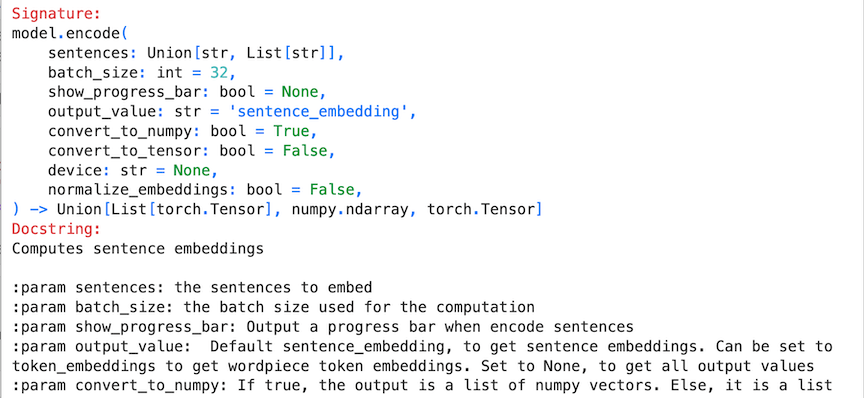)

We are going to work solely with the `model.encode` method for our text embedding creation.  There is a surprising amount of work being done under the hood with this function to include word tokenization, batching, GPU device setting, etc. If you really must know, feel free to review [lines 111 - 202 in the sentence-transformers Github repo](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/SentenceTransformer.py).  Here's a few notes for our course:
- `sentences`: accepts either a single string or a list of strings.  Very convenient.  This will allow us to enter all of the chunks from a single podcast episode at once, allowing for efficient processing and episode integrity.
- `batch_size`: under the hood the list of sentences in the input is batched.  Default is 32, so if your input was 128 sentences, then the model would translate that into 4 batches for processing.  DataLoader not needed.  Assuming you are using Google Colab for this notebook, use the default setting.
- `convert_to_numpy`: default output is a numpy array. However, because Weaviate does not accept the np.array data type, we'll want to eventually convert these arrays into Python lists.
- `device`: set to either cpu or GPU (`"cuda:0"`) for single GPU.  If `None` the function will handle this step for you and choose the fastest option! 

Let's take a quick tour of how this function works in practice.

In [59]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [86]:
#create sample sentences
text1 = "I ran down the road"
text2 = "I ran down the street"
text3 = "I ran down the lane"
text4 = "I ran down the avenue"
text5 = "I ran over to the house"

In [87]:
road_sentences = [text1, text2, text3, text4, text5]
road_vectors = model.encode(road_sentences)

In [88]:
road_vectors, road_vectors.shape

(array([[ 0.01464685,  0.0561101 ,  0.02563804, ..., -0.0925348 ,
         -0.04195407, -0.04409865],
        [ 0.04675803,  0.07742155,  0.04562965, ..., -0.0812416 ,
         -0.10972543, -0.02546268],
        [ 0.06553327,  0.0994243 , -0.04012905, ...,  0.00221833,
         -0.0342925 , -0.04802397],
        [ 0.05736331,  0.08300827,  0.00926694, ..., -0.10420122,
         -0.10806054, -0.03672466],
        [ 0.06660569,  0.03724336,  0.02164606, ..., -0.01440302,
         -0.1198651 ,  0.00423094]], dtype=float32),
 (5, 384))

As mentioned earlier the output vector dimension is 384 for this model, so we should expect to see 5 vectors of length 384 dims.  
Given that all of these vectors are of the same length we can compare them in vector space using a cosine simlarity function.  
The sentence-transformer's `semantic_search` function allows us to compare a single text (or multiple) to multiple texts and ranks them based on distance in vector space.  

In [89]:
from sentence_transformers.util import semantic_search

# we need to reencode our texts here with pytorch tensors to work with the semantic_search function
tensors = model.encode(road_sentences, convert_to_tensor=True)

# we'll set our query to the first sentence
query = model.encode(text1, convert_to_tensor=True)

#compare our query with all of the other sentences, including itself (expect to see a cossim value of 1)
results = semantic_search(query_embeddings=query, corpus_embeddings=tensors)[0]
for result in results:
    print(f'Score: {round(result["score"],3)} - {road_sentences[result["corpus_id"]]}')

Score: 1.0 - I ran down the road

Score: 0.905 - I ran down the street

Score: 0.823 - I ran down the lane

Score: 0.805 - I ran down the avenue

Score: 0.673 - I ran over to the house

Here we can see that the word `road` is most semantically similar to itself, followed by the word `street`, followed by `lane`, and finally followed by `avenue`.  The final entry "`I ran over to the house`" is much further away in vector space, relatively, than the other sentences. As discussed in the course notes, embeddings measures the similarity between strings.  The next example shows how this concept of "similarity" is not always as intuitive as one might think.

In [90]:
#define some semantically similar sentences 
passages = ['Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams',
            'Tom Bilyeu founded Quest Nutrition in 2010',
            'Tom Bilyeu, not known outside of those who listen to the Impact THeory',
            'Tom Bilyeu claims to have deadlifted 335 pounds on his show',
            'Tomcats are not neutered cats']

#we'll define a query that should be able to be answered by the passages
query = "Who is Tom Bilyeu"

tom_tensors = model.encode(passages, convert_to_tensor=True)
tom_query = model.encode(query, convert_to_tensor=True)
tom_results = semantic_search(query_embeddings=tom_query, corpus_embeddings=tom_tensors)
for result in tom_results[0]:
    print(f'Score: {round(result["score"],3)} - {passages[result["corpus_id"]]}')

Score: 0.709 - Tom Bilyeu, not known outside of those who listen to the Impact THeory

Score: 0.671 - Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams

Score: 0.67 - Tom Bilyeu founded Quest Nutrition in 2010

Score: 0.639 - Tom Bilyeu claims to have deadlifted 335 pounds on his show

Score: 0.248 - Tomcats are not neutered cats